# DL Assignment 2 - Report

Shahar Bardugo   208496687

Leah Wachtfogel  206098931

## Installations and Imports

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 22.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator as generator
from PIL import Image
from zipfile import ZipFile
import visualkeras
from numpy import delete

## Parameters

In [ ]:
BATCH_SIZE = 32
MAX_EPOCH = 100
VAL_SPLIT = 0.2
TRAIN_SIZE = 2200
TEST_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_SIZE*(1-VAL_SPLIT)//BATCH_SIZE
VAL_STEPS = TRAIN_SIZE*VAL_SPLIT//BATCH_SIZE

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#path = "/content/drive/MyDrive/Msc_BGU/Deep_Learning/" #Leah
#path = "/content/drive/MyDrive/Deep_Learning_Ass2/Deep_Learning/" #Shahar
path = "/content/drive/MyDrive/Deep_Learning/" #Shahar
data_path = path + "lfwa.zip"

In [ ]:
with ZipFile(data_path, 'r') as zipObj:
  zipObj.extractall()

In [ ]:
def read__pairs_file(file_name):
  """
  Description: Takes a file with 2 image names and their label and returns their paths and the labels. 
  Input:
    file_name - txt file with a list of pairs of names of images and a label
  Output: 
    df - each row containing 2 paths to the images and a label
  """
  with open(file_name) as f:
    next(f)
    lines = f.read().splitlines()

  path_list = "/content/lfw2/lfw2/"
  df = pd.DataFrame(columns = ["Path1", "Path2", "y_col"])
  for i, line in enumerate(lines):
    line_list = line.split("\t") 
    if len(line_list) == 3:
      path1 = path_list + f'{line_list[0] }/{line_list[0]}_{int(line_list[1]):04}.jpg'
      path2 = path_list + f'{line_list[0] }/{line_list[0]}_{int(line_list[2]):04}.jpg'
      label = "1"
    if len(line_list) == 4:       
      path1 = path_list + f'{line_list[0] }/{line_list[0]}_{int(line_list[1]):04}.jpg'
      path2 = path_list + f'{line_list[2] }/{line_list[2]}_{int(line_list[3]):04}.jpg'
      label = "0"
    df.loc[i] = [path1 ,path2 , label]
  return df      
  

In [ ]:
def imgs_generators(data_frame, set_type):
  """
  Description: generates two images as matrices and a label according to batch size, and rescales image to 105X105
  Input:
    data_frame - ach row containing 2 paths to the images and a label
    set_type - string "train" or "test" 
  Output: 
    imgs_gen - iterable with two image matrices and a label in list
  """
  if set_type == "train":
    batch_size = BATCH_SIZE
    gen = generator(rescale = 1/255 , validation_split = VAL_SPLIT)
  if set_type == "test":  
    batch_size = 1
    gen = generator(rescale = 1/255)
    
  gen1 = gen.flow_from_dataframe(
    data_frame, 
    x_col='Path1',
    y_col='y_col',
    target_size=(105 , 105),
    color_mode = "grayscale",
    class_mode='binary',
    batch_size = batch_size, 
    shuffle=False,
    seed=7
  )
  gen2 = gen.flow_from_dataframe(
    data_frame, 
    x_col='Path2',
    y_col='y_col',
    target_size=(105 , 105),
    color_mode = "grayscale",
    batch_size = batch_size,
    class_mode='binary',
    shuffle=False,
    seed=7
  )
  while True:
     x_1 = gen1.next()
     x_2 = gen2.next()
     yield [x_1[0], x_2[0]], x_1[1]
     

In [ ]:
data_frame_train = read__pairs_file(path+"pairsDevTrain.txt")
data_frame_test = read__pairs_file(path+"pairsDevTest.txt")

# model

In [ ]:
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models, Input ,Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

In [ ]:
def calculate_distance(tensors):
    return abs(tensors[0] - tensors[1])


In [ ]:
def siamese_model():
  """
  Implementation of siamese network with the different layers and initializiation according to the paper.
  """
  img1 = Input((105 , 105, 1))
  img2 = Input((105 , 105, 1))

  Siamese_model = models.Sequential()
  # Initialize weights and biases
  W1_init = tf.keras.initializers.RandomNormal(mean=0, stddev=0.01 , seed = 4)
  b1_init = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01 , seed = 42)
  W2_init = tf.keras.initializers.RandomNormal(mean=0, stddev=0.01, seed = 10)
  b2_init = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01, seed = 26)
  W3_init = tf.keras.initializers.RandomNormal(mean=0, stddev=0.01, seed = 28)
  b3_init = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01, seed = 7)
  W4_init = tf.keras.initializers.RandomNormal(mean=0, stddev=0.01, seed = 11)
  b4_init = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01, seed = 2)
  
  Siamese_model.add(layers.Conv2D(64, (10, 10), activation='relu', input_shape=(105, 105, 1), kernel_initializer= W1_init , bias_initializer= b1_init))
  Siamese_model.add(layers.BatchNormalization())
  Siamese_model.add(layers.MaxPooling2D((2, 2)))
  Siamese_model.add(layers.Dropout(rate=0.1))

  Siamese_model.add(layers.Conv2D(128, (7, 7), activation='relu', kernel_initializer= W2_init , bias_initializer= b2_init))
  Siamese_model.add(layers.BatchNormalization())
  Siamese_model.add(layers.MaxPooling2D((2, 2)))
  Siamese_model.add(layers.Dropout(rate=0.1))

  Siamese_model.add(layers.Conv2D(128, (4, 4), activation='relu', kernel_initializer= W3_init , bias_initializer= b3_init))
  Siamese_model.add(layers.BatchNormalization())
  Siamese_model.add(layers.MaxPooling2D((2, 2)))
  Siamese_model.add(layers.Dropout(rate=0.1))

  Siamese_model.add(layers.Conv2D(256, (4, 4), activation='relu',  kernel_initializer= W4_init , bias_initializer= b4_init))
  Siamese_model.add(layers.BatchNormalization())

  W_D_init = tf.keras.initializers.RandomNormal(mean=0, stddev=0.2, seed = 10)
  b_D_init = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01, seed = 1)

  Siamese_model.add(layers.Dense(4096 , activation = "sigmoid", kernel_initializer= W_D_init , bias_initializer= b_D_init))
  Siamese_model.add(layers.Flatten())

  # output vectors from 2 identical networks (pair of images) to get a single output based on their distance
  feature_vector_1 = Siamese_model(img1)
  feature_vector_2 = Siamese_model(img2)
  Distance_layer = abs(tf.subtract(feature_vector_1 , feature_vector_2))

  W_out_init = tf.keras.initializers.RandomNormal(mean=0, stddev=0.2, seed = 100)
  b_out_init = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01, seed = 97)
  prediction = layers.Dense(1, activation = 'sigmoid',kernel_initializer = W_out_init , bias_initializer= b_out_init)(Distance_layer)

  siamese_net = tf.keras.Model(inputs = [img1 , img2] , outputs = prediction)

  return siamese_net
  

In [ ]:
#Learning scheduler. Learning rates are decayed by 1 percent per epoch
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=(len(data_frame_train) * VAL_SPLIT) // BATCH_SIZE,
    decay_rate=0.99, staircase = True)


In [ ]:
# training the model with early stopping condition of no improvement for 5 epochs by 0.001
data_frame_train = shuffle(data_frame_train)
imgs_gen = imgs_generators(data_frame_train, "train")

model = siamese_model()
model.compile(optimizer = Adam( learning_rate=lr_schedule),  loss = tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])#from_logits = True))#"binary_crossentropy") 
early_stoppinig_loss = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=6,
    mode="min",
    verbose = 1,
    restore_best_weights=True,
    min_delta = 0.001
)
history = model.fit(imgs_gen,
                    epochs = MAX_EPOCH,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS,
                    callbacks = [early_stoppinig_loss],
                    verbose=1)



Found 2200 validated image filenames belonging to 2 classes.
Found 2200 validated image filenames belonging to 2 classes.
Epoch 1/100
55/55 [==============================] - 10s 90ms/step - loss: 31.6237 - binary_accuracy: 0.5562
Epoch 2/100
55/55 [==============================] - 6s 101ms/step - loss: 30.8596 - binary_accuracy: 0.5634
Epoch 3/100
55/55 [==============================] - 5s 99ms/step - loss: 32.3892 - binary_accuracy: 0.5805
Epoch 4/100
55/55 [==============================] - 5s 89ms/step - loss: 26.6322 - binary_accuracy: 0.5925
Epoch 5/100
55/55 [==============================] - 5s 96ms/step - loss: 13.7229 - binary_accuracy: 0.6227
Epoch 6/100
55/55 [==============================] - 5s 96ms/step - loss: 10.4658 - binary_accuracy: 0.6684
Epoch 7/100
55/55 [==============================] - 5s 89ms/step - loss: 9.1469 - binary_accuracy: 0.7072
Epoch 8/100
55/55 [==============================] - 6s 102ms/step - loss: 8.7329 - binary_accuracy: 0.7123
Epoch 9/100
5

# Evaluation

In [ ]:
# calculate model accuracy
data_frame_test = shuffle(data_frame_test)
imgs_gen_test = imgs_generators(data_frame_test, "test")
loss = model.evaluate(imgs_gen_test, steps = TEST_SIZE)
loss

Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
1000/1000 [==============================] - 8s 8ms/step - loss: 6.3393 - binary_accuracy: 0.7000


[6.339277744293213, 0.699999988079071]

In [ ]:
history.history

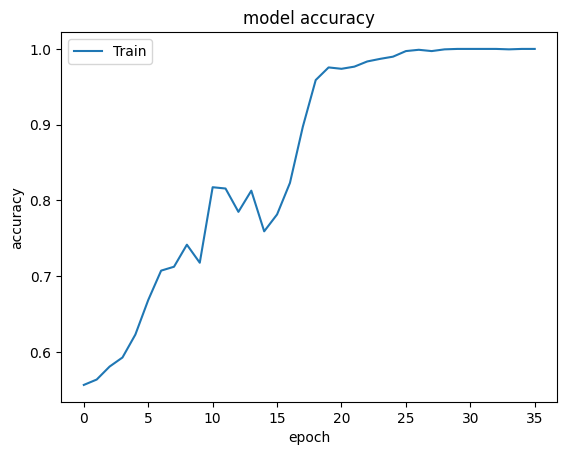

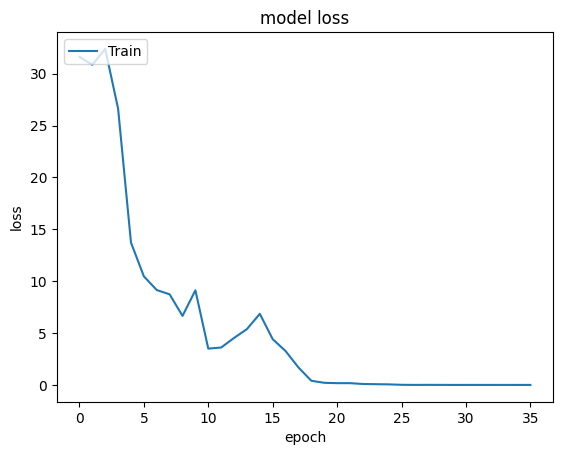

In [ ]:
# summarize history for accuracy
#plt.plot(history.history['accuracy'])
plt.plot(history.history['binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Prediction examples

Found 8 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
1/1 [==============================] - 0s 24ms/step
ARE PHOTOS OF SAME PERSON?
model prediction: True, real: True




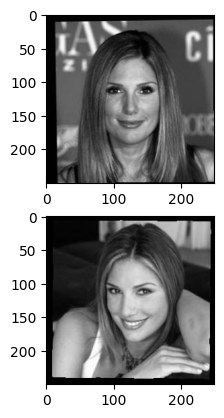

1/1 [==============================] - 0s 28ms/step
ARE PHOTOS OF SAME PERSON?
model prediction: True, real: True




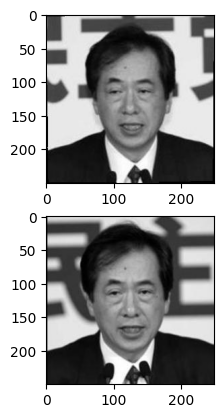

1/1 [==============================] - 0s 28ms/step
ARE PHOTOS OF SAME PERSON?
model prediction: True, real: True




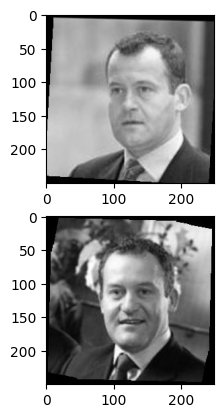

1/1 [==============================] - 0s 25ms/step
ARE PHOTOS OF SAME PERSON?
model prediction: False, real: True




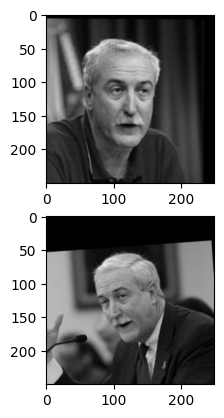

1/1 [==============================] - 0s 24ms/step
ARE PHOTOS OF SAME PERSON?
model prediction: True, real: False




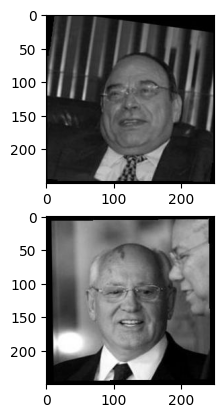

1/1 [==============================] - 0s 30ms/step
ARE PHOTOS OF SAME PERSON?
model prediction: True, real: False




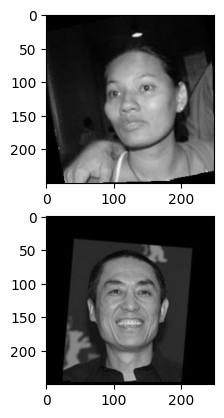

1/1 [==============================] - 0s 31ms/step
ARE PHOTOS OF SAME PERSON?
model prediction: False, real: False




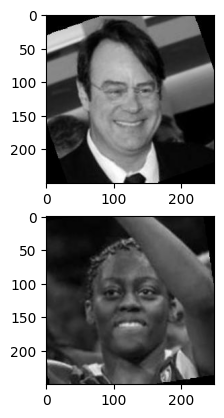

1/1 [==============================] - 0s 34ms/step
ARE PHOTOS OF SAME PERSON?
model prediction: False, real: False




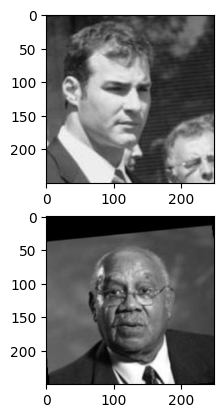

In [ ]:
# get pairs of photos examples with prediction

data_frame_sample = pd.concat([data_frame_test[data_frame_test.y_col == "1"].head(4),data_frame_test[data_frame_test.y_col == "0"].head(4)])
imgs_gen_sample = imgs_generators(data_frame_sample, "test")

for i in range(8):
  sample = next(imgs_gen_sample)
  y_pred = model.predict([sample[0]])
  real_label = data_frame_sample.iloc[i]["y_col"]
  print("ARE PHOTOS OF SAME PERSON?")
  result1 = int(y_pred[0])>0.5
  result2 = int(real_label) == 1
  print(f"model prediction: {result1}, real: {result2}\n\n")

  fig, axs = plt.subplots(2)
  img = cv2.imread(data_frame_sample.iloc[i]['Path1'])
  img2 = cv2.imread(data_frame_sample.iloc[i]['Path2'])

  axs[0].imshow(img)
  axs[1].imshow(img2)
  plt.show()